EPITA 2019 MLRF practice_06-01_mri_seg v2019-06-10_104458 by Nicolas BOUTRY and Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 06 part 01: Image segmentation

## Introduction

We will demonstrate how to leverage image description and classification techniques you have learned to create a detector of tumoral regions in MRI brain scans.

As this is the last session of this course, you will be given less indications than before.

### Objectives

It consists in building a **pixel** classifier, as opposed to an **image** classifier that you previously implemented, to assign to **each pixel** a value (here a binary value) to indicate whether the area described by this pixel is tumoral or not.

The dataset we provide is composed of *slices* of brain MRIs from different patients, each slice having 4 *modalities*, ie 4 acquisitions using 4 different tools.

The ground truth for each slice (and the segmentation you should produce for grading) indicates for each pixel whether or not it covers a tumoral regions:
- `0` means **no tumor**;
- `1` means **tumor**.

We encourage you to read the `README.md` accompanying the dataset distribution for further details.

**You will have to predict exactly the same values (either `0` or `1`) for each pixel of the test set.**

### Inputs and expected outputs
This project is based on a scientific challenge which aimed at detecting specific parts of tumoral regions, in full 3D MRIs, as illustrated below:
![Original challenge](img/practice_06/brain_tumor_types.png)


In our case, we will only consider isolated **2D slices** and predict a **binary label**.
Here is an illustration of some preliminary results we obtained on the segmentation task you have to complete – the first 4 columns are the original data, the 5th is the predicted segmentation, and the last is the expected segmentation:
![Session sample results](img/practice_06/sample_results.png)

### Agenda
We **suggest** you proceed in 12 steps, but most of then can be skipped (you should at least train one non linear classifier) if your goal is to build and validate a first version of your pipeline:

1. Load resources
2. Prepare training data, pixel-level predictions
3. Create, train and validate a linear, pixel-level classifier (**can be skipped**)
4. Use the appropriate performance metric
5. Create, train and validate a non-linear SVM classifier
6. Multi-layer Perceptron (**can be skipped**)
7. Random Forests (**can be skipped**)
8. Use more context for classification (**can be skipped**)
9. Post-process the results (**can be skipped**)
10. Train on complete dataset (**can be skipped**)
11. Process the test set
12. Export your results and submit them for grading

### Resources
The resources for this session are stored on the network.

Here is a description of the files we provide in the student's archive:
- `train_data_x.dat`: 256 normalized slices, one per patient,
  containing 240x240 images with 4 channels (1 for each modality),
  to be used for training.
- `train_data_y.dat`: 256 target segmentations, one per patient,
  containing 240x240 images with 1 channel (indicating tumor or clean region),
  to be used for training.
- `test_data_x.dat`: 29 normalized slices, one per patient (not in the training set),
  containing 240x240 images with 4 channels (1 for each modality),
  to be used for testing. **Ground truth not provided.**

The `.dat` files we use here are binary dumps of NumPy arrays exactly as they are
represented in memory.
Each file contains exactly one array.

They are meant to be "[memmapped](https://en.wikipedia.org/wiki/Memory-mapped_file)"
because it is very useful for large files — and the original dataset is large —
as it avoid to load the complete array in RAM, but instead caches pages in RAM and
load content from disk on demand.

# 1. Load resources

In [1]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sklearn
import json

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Make sure the resources location below is correct.**
</div>

In [3]:
# setup the resources location
PATH_TO_RESOURCES = "/afs/cri.epita.net/resources/teach/bigdata/mlrf19/resources/brats18"
PATH_TO_RESOURCES = "/home/nicolas.roger/afs/mlrfrendu/r3/student"

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use `np.memmap(...)` and the `README.md` file provided with the dataset to load your data.**
</div>

In [4]:
# TODO load the resources
train_data_x = np.memmap(os.path.join(PATH_TO_RESOURCES,"train_data_x.dat"), mode="r", dtype=np.float32, shape=(256, 240, 240, 4))
train_data_y = np.memmap(os.path.join(PATH_TO_RESOURCES,"train_data_y.dat"), mode="r", dtype=np.uint8, shape=(256, 240, 240,1))
test_data_x = np.memmap(os.path.join(PATH_TO_RESOURCES,"test_data_x.dat"), mode="r", dtype=np.float32, shape=(29, 240, 240, 4))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Make sure you understand how your dataset is structured. Display some slices from the training set and their associated ground truth. As you will do this often, define a simple function to show slices, segmentations, etc.**
</div>

In [5]:
# TODO
#plt.subplot(1)
# plt.imshow(train_data_x[0])
# plt.subplot(1)

## 2. Prepare training data, pixel-level predictions
Your goal is to train a pixel-level classifier, ie to create a set of pixels samples along with the expected prediction for each of them.

### 2.1 Select some slices for training
You do not want to validate your complete pipeline by training on the full dataset because this would be way too long.

We recommend to select slices (which all belong to different patients) from the original data.

**Why not taking all the pixels and splitting the pixels globally?**
Because we would not appropriately test the generalization capabilities of our classifier, as the distribution of pixel values will be the same between our training and validation sets.

Also, do not forget to compute the target values for each slice.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Select some slices for training and select the training samples from the appropriate array. We used either 3 or 10 slices in our preliminary tests.**
</div>

In [6]:
# TODO 
train_data_sample_ids =  np.random.choice(256, 3)
train_data_x_sample =  train_data_x[train_data_sample_ids]
print(train_data_x_sample.shape)

(3, 240, 240, 4)


<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Select the target values for each of the slices you previously selected.**
</div>

In [7]:
# TODO
train_data_y_sample = train_data_y[train_data_sample_ids]

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**To make sure your selection procedure is correct, you should display the slices you selected and the associated ground truth.**
</div>

In [8]:
train_data_x_sample.shape

(3, 240, 240, 4)

In [9]:
train_data_y_sample.shape

(3, 240, 240, 1)

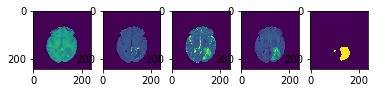

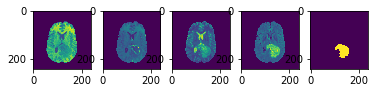

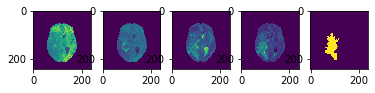

In [10]:
# TODO
# display the slices you selected
#slice_id = 0

for slice_id in range(len(train_data_x_sample)):
    fig,ax = plt.subplots(1,5)
    for modality,axn in enumerate(ax[:-1]):
        axn.imshow(train_data_x_sample[slice_id, ..., modality])

    ax[-1].imshow(train_data_y_sample[slice_id, ...,0])


### 2.2 Select some slices for validation
This is also optional but makes it much easier to validate the pipeline.

**Note that those slices should not be present in the training set.**

Do not forget to compute the target values for each slice.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Select some slices which do not belong to the sample we just created, and create a small validation set. We used either 3 or 10 slices in our preliminary tests.**
</div>

In [11]:
# TODO
val_data_sample_ids = np.setdiff1d(np.arange(256),train_data_sample_ids)[:20]
val_data_x_sample = train_data_x[val_data_sample_ids]

In [12]:
# TODO
val_data_y_sample = train_data_y[val_data_sample_ids]

### 2.3 Select the pixel from the brain (exclude the background)
**Important: adding the background pixels (the pixels where there is no information) strongly perturbs the training.**

Because we had to normalize the slices before giving them to you (normalization can only be done using the full 3D scan), we provide you with a function `slices_to_masks` which computes the masks for a stack of slices.

For each slices (with 4 modalities), it computes a mask as illustrated below:
![Mask example](img/practice_06/mask_example.png)

**You must use this mask to select only the pixels falling within the brain for training.**

In [13]:
def slices_to_masks(slices):
    '''
    Computes the foreground masks for each slice in a stack.

    Arguments
    ---------
    slices: numpy.array, shape (NUM_SLICES, 240, 240, 4)
        an array of slices for which every pixel belonging to the background has 
        the smallest possible value in each modality.

    Returns
    -------
    slices_masks: numpy.array, shape (NUM_SLICES, 240, 240), dtype numpy.bool
        the maks for each of the original slices indicating the foreground pixels.

    '''
    if slices.ndim != 4:
        raise ValueError("slices_to_masks expects as parameter an array of 4 dimensions (numslices, rows, cols, features)."
                         " It got instead an array of %s dimensions" % (slices.ndim, ))
    slices_min = np.min(slices, axis=(1, 2))
    slices_masks = np.all(slices > slices_min[:, np.newaxis, np.newaxis, :],
                          axis=-1)
    return slices_masks

In [14]:
print(train_data_x_sample.shape)
print(val_data_x_sample.shape)
mask_train_data_sample = slices_to_masks(train_data_x_sample)
mask_val_data_sample = slices_to_masks(val_data_x_sample)
mask_train_data_sample.shape

(3, 240, 240, 4)
(20, 240, 240, 4)


(3, 240, 240)

In [15]:
# for ii in range(train_data_x_sample.shape[0])[:3]:
#     display_slices(train_data_x_sample[ii], mask_train_data_sample[ii])

### 2.4 Format the training data appropriately using masks
The goal is to obtain two arrays:
- a `x` variant with shape `(number_of_pixels, number_of_features_per_pixel)`, ie `(BIG_NUMBER, 4)`;
- a `y` variant with shape `(number_of_pixels, )` ie a single column matrix where each cell indicates the target value for each pixel.

Using the masks you can build for each stack of slice, you can easily filter and reshape the 2 arrays we need:
- `train_data_x_sample`
- `train_data_y_sample`

**We will care about the validation set later as it does not need to be filtered as carefully.**

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using the mask we created, filter (and implicitly reshape) the array of observations and the array of expected results for the training sample you defined.**
</div>

In [16]:
# TODO

train_data_x_sample_masked = train_data_x_sample[mask_train_data_sample]
train_data_y_sample_masked = train_data_y_sample[mask_train_data_sample]
val_data_x_sample_masked = val_data_x_sample[mask_val_data_sample]
val_data_y_sample_masked = val_data_y_sample[mask_val_data_sample]

train_data_x_sample_masked.shape,train_data_y_sample_masked.shape
# we expect shapes like:
# - (169144, 4) for train_data_x_sample
# - (169144,) for train_data_y_sample

((48863, 4), (48863, 1))

## 3. Create, train and validate a linear, pixel-level classifier
A linear SVC with $10000$ iterations should give you a good idea of what linear classification can give you.

As a first evaluation metric, you can use the accuracy.

Displaying the results is probably the best way to have an idea of what is going on, at this stage.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create a linear classifier.**
</div>

In [17]:
# TODO
from sklearn.svm import SVC
svclassifier = SVC(gamma="scale")

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Train your linear classifier (it should take a minute or two on a modern CPU).**
</div>

In [18]:
# Check the shape of your inputs before firing the training!
train_data_x_sample_masked.shape, train_data_y_sample_masked.shape

((48863, 4), (48863, 1))

In [19]:
# TODO
svclassifier.fit(train_data_x_sample_masked, train_data_y_sample_masked)

/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Evaluate the performance of your linear classifier on your sample validation set. Do not forget to reshape your arrays so the input array has a shape of `(num_pixels, 4)` and the array of expected outputs has a shape of `(num_pixels,)`. Use the `score()` method of your classifier for now.**
</div>

In [20]:
# What is the current shape of the validation sample?
val_data_x_sample_masked.shape

(344991, 4)

In [21]:
# TODO
svclassifier.score(val_data_x_sample_masked, val_data_y_sample_masked)

0.9534422637112272

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**The score is not very informative because the classes are imbalanced. Use other tools like `classification_report` or `confusion_matrix` to analyse your results. You will need to compute and store the predictions for your validation set.**
</div>

In [22]:
from sklearn.metrics import classification_report, confusion_matrix  

In [ ]:
# TODO
# compute the predictions
val_data_ypred_sample = svclassifier.predict(val_data_x_sample_masked)

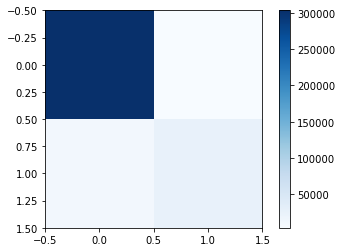

In [27]:
# TODO
cm = confusion_matrix(val_data_y_sample_masked, val_data_ypred_sample)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

In [28]:
# TODO
print(classification_report(val_data_y_sample_masked, val_data_ypred_sample))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    307442
           1       0.86      0.68      0.76     37549

    accuracy                           0.95    344991
   macro avg       0.91      0.83      0.87    344991
weighted avg       0.95      0.95      0.95    344991



<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Display some of the results obtained on the validation set. You need to reshape the predictions (the original slices are 240x240).**
</div>

In [35]:
# TODO
print(val_data_y_sample.shape, val_data_ypred_sample.shape)
display_data_y = val_data_y_sample_masked.reshape(-1,240,240,1)

# for slice_id in range(len(train_data_x_sample)):
#     fig,ax = plt.subplots(1,5)
#     for modality,axn in enumerate(ax[:-1]):
#         axn.imshow(train_data_x_sample[slice_id, ..., modality])

#     ax[-1].imshow(train_data_y_sample[slice_id, ...,0])



(20, 240, 240, 1) (344991,)


ValueError: cannot reshape array of size 344991 into shape (240,240,1)

You may obtain very different results here between runs because of sampling randomness, SGD randomness, etc.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Are you satisfied with the performance of your classifier? Write down why below.**
</div>

TODO

The performance of this first classifier is good/bad because…

## 4. Use the appropriate performance metric
At this point, it is very important to ask ourselves what is the criterion we want to optimize.

Clearly, the fraction of non-tumoral pixels is not very informative, because the classes are strongly imbalanced.

Instead, we suggest to focus on how well we detect each tumor:
- Do we recover all its pixels?
- Do we add noise to the detection?

We will summarize both of these indicators in a single one.

### Evaluation for grading
We will use the [*Sørensen–Dice coefficient*](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate the quality of your predictions on the test set (with hidden ground truth).
Given two sets, X and Y, it is defined as:
$$
Dice(X,Y) = \frac{2 | X \cap Y |}{|X| + |Y|}
$$
where $|X|$ and $|Y|$ are the cardinalities of the two sets.

Its values range from $0$ (worst) to $1$ (best).

In the medical image processing community, this indicator is best know as the "Dice coefficient", "Dice score", or simply "Dice".

It is [equivalent to the F1-score](https://brenocon.com/blog/2012/04/f-scores-dice-and-jaccard-set-similarity/), and when applied to boolean data, using the definition of true positive (TP), false positive (FP), and false negative (FN), it can be written as:
$$
Dice = \frac{2TP}{2TP+FP+FN}
$$

There are several ways to compute it, and we list some hereafter.

#### a) Read it from the classification report
Scikit-learn's `classification_report()` function outputs several valuable indicators.
The one we are considering is the f1-score for class `1`, which is `0.83` in the following report (an example of the performance we obtained on our validation set when training a MLP classifier with a sample of features pooled over a 3x3 window, after post-processing):
```
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    547247
           1       0.95      0.73      0.83     19193

   micro avg       0.99      0.99      0.99    566440
   macro avg       0.97      0.87      0.91    566440
weighted avg       0.99      0.99      0.99    566440
```

#### b) Use the confusion matrix 
We can compute the Dice coefficient using the true/false positives/negatives provided by the confusion matrix (Scikit-learn's `confusion_matrix()`).

#### c) Compute it directly
This function is quite easy to code and it may allow us to add more tests to ensure we did our job correctly.
We provide you, below, with a `dice_score` function which does this. **This is the function we will use to measure the performance of your classifier.**

In [ ]:
import warnings

def dice_score(y_true, y_pred):
    '''Compute the Dice coefficient between true and predicted values.'''
    for var, name in ((y_true, "y_true"), (y_pred, "y_pred")):
        if not isinstance(var, np.ndarray):
            raise ValueError("dice_score: `%s` must be a numpy array. Got object of type %s instead."
                             % (name, type(var)))
        if var.ndim != 1:
            raise ValueError("dice_score: `%s` must be 1-dimensional. Got %s.ndim=%d instead."
                             % (name, name, var.ndim))
        if not (var.dtype == np.uint8 or var.dtype == np.bool):
            warnings.warn("dice_score: `%s` should be either of type np.uint8 or np.bool. "
                          "Got %s instead. "
                          "Values will be projected on {0,1}."
                          % (name, var.dtype))

    if y_true.shape != y_pred.shape:
        raise ValueError("dice_score: `y_true` and `y_pred` must have the same shape. "
                         "Got y_true.shape=%s and y_pred.shape=%s instead."
                         % (y_true.shape, y_pred.shape))
    y_true_ = y_true != 0  # Project over {False,True}
    y_pred_ = y_pred != 0
    # The boolean union removes the duplicate intersection!
    union = np.sum(y_true_ + y_pred_)
    if union == 0:
        warnings.warn("dice_score: neither `y_true` nor `y_pred` contain positive values."
                      " The score is ill-defined. Returning `1.` without much faith...")
        return 1.
    inter = np.sum(y_true_ * y_pred_)
    # We need to re-add the intersection or we get the Jaccard index
    return 2 * inter / (union + inter)

In [ ]:
# Try it!
dice_score(val_data_y_sample.reshape((-1,)), val_data_ypred_sample)

# 5. Create, train and validate a non-linear SVM classifier
The SVM with RBF kernel is a very classical non-linear classifier.

Let's see how well it can perform on our samples.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create a non-linear SVM classifier.**
</div>

In [ ]:
# TODO
# svclassifier = sklearn.???

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Reuse the code you wrote in the previous step to train and validate you classifier. Do not forget to display some results.**
</div>

In [ ]:
# TODO
# svclassifier.???

In [ ]:
# TODO
# compute the predictions
# val_data_ypred_sample = ???

In [ ]:
# TODO
# confusion_matrix(...) or classification_report(...) or dice_score(...)

In [ ]:
# TODO
# display some results

You should consistently get better results with this classifier (on this problem), but it is much slower.

There are [two main parameters for a RBF SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html): C and $\gamma$ (gamma). It would perfectly make sense to perform a [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search) of the best possible parameter pair. If you go this way, and we strongly encourage you to do so, make sure to use [all](https://scikit-learn.org/stable/modules/grid_search.html) [the](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) [goodies](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) Scikit-learn offers!

But first, make sure you try the other options we suggest.

## 6. Multi-layer Perceptron
The MLP is a very powerful classifier, despite its strong tendency to overfit when used without care.

There are very powerful libraries for training neural networks nowadays, and you should use them.

However, for the sake of rapidity, we will use Scikit-learn's implementation for our first experiments. It uses a parallel CPU version and is easier than the majors libraries like [Keras](http://keras.io/), [Tensorflow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/), [MS CNTK](https://docs.microsoft.com/en-gb/cognitive-toolkit/), [Apache MXNet](https://mxnet.incubator.apache.org/) and others.

In [ ]:
from sklearn.neural_network import MLPClassifier

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create a non-linear MLP classifier, train it, and measure its performance on your validation sample.**
</div>

*Tips:*
- use relu activations with a small regularization loss (`1e-6` or so);
- use the "adam" solver with large batch size (we tried `256` with success);
- use few hidden layers with few units to start (we tried with two layers of 16 and 4 units respectively);
- as Scikit-learn's implementation integrate an early stopping mechanism by default, we can set the maximum number of iterations to a quite high number (like `100`).

In [ ]:
# TODO
# mlpclf1 = MLPClassifier(???)

In [ ]:
# TODO
# compute the predictions
# val_data_ypred_sample = ???

In [ ]:
# TODO
# confusion_matrix(...) or classification_report(...) or dice_score(...)

In [ ]:
# TODO
# display some results

## 7. Random Forests
We could also try a Random Forest Classifier, but it you are short in time then just skip this section.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Benchmark a Random Forest Classifier if you have time..**
</div>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# TODO train, compute predictions, compute score, display some results…

## 8. Use more context for classification
**This is a tedious part, and you should skip it if you do not have enough time.**
*Note, however, that it should improve your results significantly.*

Until now, we used only 4 values to predict the class of a pixel: the normalized intensity values for each modality at this exact pixel location.

We can improve our results by looking around each pixel and using those values to compute the class of the central pixel.

This is exactly what convolutional neural networks do: at each stage, the new features are computed by looking simultaneously at:
- a neighborhood of pixels (centered around a particular pixel of interest);
- the values of the features produced by the previous layer (or the input) for all those pixels.

#### Sliding windows
We will implement this by building a new training matrix with more features.
We will proceed as follows. Given a certain window size, for all slices, we will compute a new slice where each pixel will have as features the features of all the pixels within the window around the pixel at the same coordinate in the original slice.

It can be viewed as a virtual **sliding window** over the pixels of the original slice.

The figure below is an attempt at explaining this idea visually, with a 3x3 window…
![3x3 pooling](img/practice_06/window3x3.png)

To accomplish this step, the Scikit-image function [`util.view_as_windows()`](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.view_as_windows) is very helpful.

There is [an interesting discussion on SO](https://stackoverflow.com/questions/45327829/fastest-way-to-select-77-neighbor-pixels-for-every-pixel-in-an-image-in-python) about this.

#### Padding
The challenge with this approach is to handle the border of the slices: without any special care, the resulting slice will be smaller than the original one: its new shape will be `(orig_rows - win_size + 1, orig_cols - win_size + 1)`.

We can either post-process the slices by adding the missing border, or pre-process the slices by adding them an extra border which will be removed afterward.

Pre-processing the slices is actually simpler because it avoids having to perform complicated reshaping later on for the evaluation.

To accomplish this step, the NumPy function [`np.pad()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) is very helpful.

#### About the ground truth
The ground truth slices should keep the same shape.

#### Masking
Of course, **you still need to filter out the background pixels,** like we do since step 2.
The good news is that the function `slices_to_masks()` we gave you can be applied on the resulting slices (with more than 4 dimensions). It may, however, remove a border from the brain…
Any fix regarding this issue is welcome.

### 8.1 Recompute a sample

We need to recover our training sample with its original shape, using the same data as before to facilitate comparisons between the approaches.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Recreate the training sample with shape `(n_slices, 240, 240, 4)` for x and `(n_slices, 240, 240)` for y.**
</div>

In [ ]:
# TODO
# train_data_x_sample = ???
# train_data_y_sample = ???
# train_data_x_sample.shape, train_data_y_sample.shape

### 8.3 Padding, windowed view, reshaping

First, we suggest you use a small window size to begin with, as the memory requirements grow in O(n²) with the size of your window.

Second, we also suggest you carefully implement a function which will:
- pad the original data;
- build new slices by stacking features from neighbor pixels;
- reshape the sample appropriately so its mask can be computed easily.

To guide you throughout theses steps, we will help you performing them separately at first.

In [ ]:
win_size = 3  # Must be odd

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create a padded training sample, according to the `window_size` you defined.**
</div>

*Tips:*
- You **must not** change the number of slices not the number of features.
- You must add `(win_size - 1) // 2` pixels before the first row and columns, and after the last row and column of your array.
- You should just copy the values at the edge as they should belong to the background.
- If `train_data_x_sample.shape` is `(10, 240, 240, 4)` and `win_size = 3`, then `train_data_x_sample_padded.shape` must be `(10, 242, 242, 4)`.

In [ ]:
# Check the shape of the training sample
train_data_x_sample.shape

In [ ]:
# TODO pad your sample
# train_data_x_sample_padded = np.pad(train_data_x_sample, ???)
# train_data_x_sample_padded.shape

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now use `skimage.util.view_as_windows` to view your training sample as a windowed image.**
</div>

*Tips:*
- If `train_data_x_sample_padded.shape` is `(10, 242, 242, 4)` and `win_size = 3`, then `train_data_x_sample_win.shape` should be `(10, 240, 240, 1, 1, 3, 3, 4)`. This is a bit weird but easy to fix.

In [ ]:
from skimage import util

In [ ]:
# TODO
# train_data_x_sample_win = util.view_as_windows(train_data_x_sample_padded, 
#                                                ???)
# train_data_x_sample_win.shape

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Fix the shape of `train_data_x_sample_win` so it has 4 dimensions: `(slices, rows, cols, features)`.**
</div>

In [ ]:
# TODO
# train_data_x_sample_win = train_data_x_sample_win.reshape(???)
# train_data_x_sample_win.shape

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now complete the function below which takes a training array, a window size, and returns a new array with features pooled locally over a sliding window.**
</div>

In [ ]:
# TODO
# def pool_local_features(training_array, win_size):
#     if training_array.ndim != 4:
#         raise ValueError("pool_local_features: training_array must be 4-dimensional. "
#                          "We got training_array.ndim=%d instead." % training_array.ndim)
#     if training_array.shape[1:] != (240, 240, 4):
#         raise ValueError("pool_local_features: training_array shape must be (num_slices, 240, 240, 4). "
#                          "We got training_array.shape=%s instead." % (training_array.shape,))
#     ???

### 8.4 Compute the mask of the new training sample
As said previously, we still need to filter the background pixels.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute and apply the masks for each slices using the `slices_to_masks()` function we provided.**
</div>

In [ ]:
# TODO
# mask_train_data_sample_win = ???
# mask_train_data_sample_win.shape

In [ ]:
# TODO
# train_data_x_sample_win = ???  # apply mask
# train_data_x_sample_win.shape

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the ground truth for those observations. Thanks to the padding we just need to apply the filter to `train_data_y_sample`.**
</div>

In [ ]:
# TODO
# train_data_y_sample_win = ???   # apply mask
# train_data_y_sample_win.shape

### 8.5 Train again!
You are now ready to train your favorite classifier one more time.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Retrain a MLP classifier (or another one as per your preferences) on this new sample. Do not forget to create another classifier to avoid reusing the previously-computed weights.**
</div>

In [ ]:
# TODO
# mlpclf2 = MLPClassifier(???)
# mlpclf2.fit(...)

### 8.6 Evaluation
To evaluate our classifier we need to perform the same transformation over our validation sample.

That was the purpose of creating the `pool_local_features()` function!

In [ ]:
# Here is the validation sample
val_data_x_sample_win = pool_local_features(val_data_x_sample, win_size)
val_data_x_sample_win.shape

In [ ]:
# and the associated ground truth: no change required!
val_data_y_sample_win = val_data_y_sample
val_data_y_sample_win.shape

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now evaluate this new classifier.**
</div>

In [ ]:
# TODO
# compute the predictions
# val_data_ypred_sample = ???

In [ ]:
# TODO
# print(classification_report(...)) or dice_score or …

In [ ]:
# TODO
# display some results

We should get a significant improvement with this step.

## 9. Post-process the results
**Note: this step brings you the last percents you can get, make sure you complete the previous steps before.**

The results are a bit noisy and we have some prior knowledge on the structure of the regions we expect.

We will improve the results by:
1. filtering the small isolated pixels which probably are noise;
2. fill small holes within large tumoral regions as they probably are missed elements.

We can use simple morphological tools to perform those two steps.

Scipy has two tools for this purpose:
- `scipy.ndimage.binary_opening()`
- `scipy.ndimage.binary_fill_holes`

`binary_opening` needs a structuring element which can be created with `scipy.ndimage.generate_binary_structure()`.

For both of those functions, the slices need to be processed separately.

In [ ]:
import scipy
# Here is how we create our structuring element
struct = scipy.ndimage.generate_binary_structure(2, 2)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using the morphology functions we previously mentioned, filter your results to improve them. You may need to reshape `val_data_ypred_sample`.**
</div>

In [ ]:
scipy.ndimage.binary_fill_holes?

In [ ]:
# TODO
# filter your slices
# for slice_ in val_data_ypred_sample.reshape(???):
#     ??? = scipy.ndimage.binary_opening(???)
#     ??? = scipy.ndimage.binary_fill_holes(???).astype(int)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Measure the improvements of this post-processing step, and do not forget the check the results visually.**
</div>

In [ ]:
# TODO
# print(classification_report) or dice_score or …

In [ ]:
# TODO
# display some results

## 10. Train on complete dataset

Training on the complete dataset should give us the best performance.
However, it may also take a long time and require a lot of computing resources.
Also, it is always a good idea to **keep a separate subset for validating** the performance of the predictor you trained.

Make sure you run this on a machine with enough RAM.

In a production environment, when using neural networks, we would use a dedicated library (like Keras and others), or a least carefully use the `warm_start` of Scikit-learn classifiers which support this option as it permit to learn incrementally on batches.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**If you have time, try a training on the full training set. Do not forget to validate the performance of your classifier!**
</div>

In [ ]:
# TODO
# process the full dataset

## 11. Process the test set
Using the best classifier among the ones you trained, process the test set which will be used for grading.

Remember to:
- prepare data (especially if you pool features over local windows);
- predict the classes;
- apply post processing;
- control them visually!

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Process the test set.**
</div>

In [ ]:
# TODO perform all the required steps
# ??? # preprocessing
# test_data_ypred = bestclassifier.predict(???)  # prediction
# ??? # post processing
# ??? # control

## 12. Export your results and submit them for grading
**This is the most important part!**

Using the function we provide below, check and export your results, then submit them for grading.

In [ ]:
def export_test_predictions(test_ypred, filename='test_data_ypred.dat'):
    expected_shape = (29, 240, 240)
    expected_dtype = np.uint8
    # Check shape
    if test_ypred.shape != expected_shape:
        raise ValueError("export_test_predictions: your prediction do not have the right shape."
                         " Expected shape %s but got %s instead." % (expected_shape, test_ypred.shape))
    # Check dtype
    if test_ypred.dtype != expected_dtype:
        raise ValueError("export_test_predictions: your prediction do not have the right dtype."
                         " Expected dtype %s but got %s instead." % (expected_dtype, test_ypred.dtype))
    # Check values
    if np.sum(test_ypred == 1) + np.sum(test_ypred == 0) != np.prod(expected_shape):
        raise ValueError("export_test_predictions: your prediction should contain only binary (0 and 1)"
                         " values. It seems that you have other values.")
    # Seems ok
    test_data_ypred = np.memmap(filename, mode="w+", dtype=expected_dtype, shape=expected_shape)
    test_data_ypred[...] = test_ypred  # copy values
    # The buffer is automatically flushed on disk upon object destruction but can also be explicit
    test_data_ypred.flush()
    print("Wrote '%s'." % filename)

In [ ]:
export_test_predictions(test_data_ypred.reshape((29, 240, 240)))

# Job done!
Thanks for attending MLRF19.

We hope you enjoyed solving those sessions as much as we did preparing them.

And remember: noise, bias and variance are your enemies.